In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import re
import os
import numpy as np
from tqdm import tqdm
import easyocr as eo
import cv2

/Users/daaa/opt/miniconda3/envs/data-science-ml-dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_df = pd.read_json('./data/dev.jsonl', lines=True)
val_df.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


In [3]:
val_df['img'] = './data/' + val_df['img']
val_df.head()

,id,img,label,text
0,8291,./data/img/08291.png,1,white people is this a shooting range
1,46971,./data/img/46971.png,1,bravery at its finest
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,./data/img/80243.png,1,mississippi wind chime


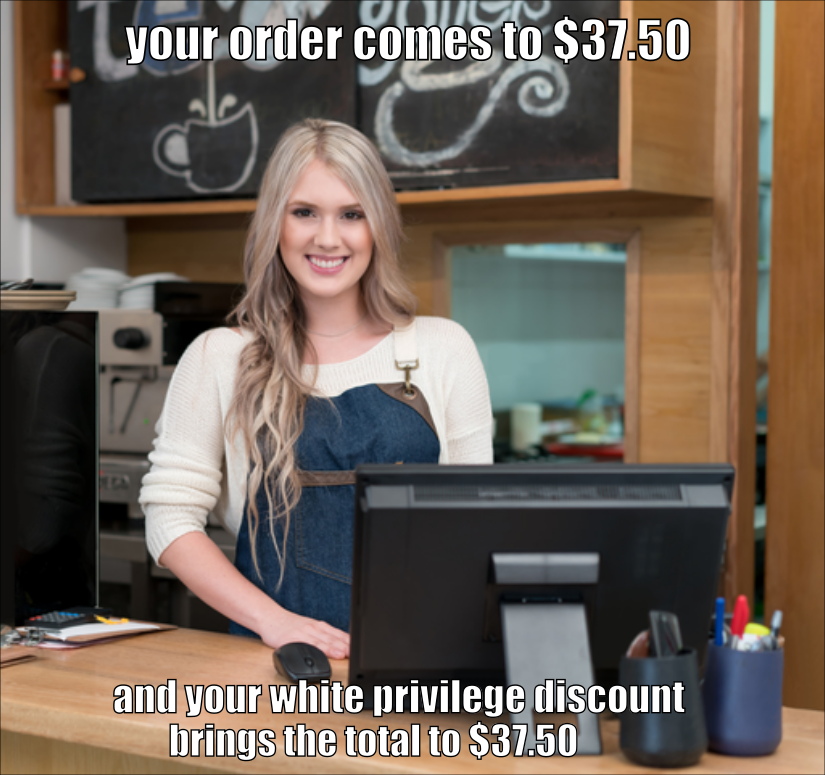

In [4]:
Image.open(val_df.iloc[2, 1])

## Text Processing

In [5]:
def masking_usernames(text): 
    username_pattern = r'@\w+'
    return re.sub(username_pattern, '[USERNAME]', text)

def filter_long_text(text): 
    if len(text.split(" ")) > 100: 
        return False
    return True

def text_preprocessing_pipeline(text): 
    if filter_long_text(text):
        text = masking_usernames(text)
    else:
        return None
    return text

In [6]:
val_df['processed_text'] = val_df['text'].apply(text_preprocessing_pipeline)

In [7]:
val_df[val_df["processed_text"] == None]

,id,img,label,text,processed_text


In [8]:
val_df.head()

,id,img,label,text,processed_text
0,8291,./data/img/08291.png,1,white people is this a shooting range,white people is this a shooting range
1,46971,./data/img/46971.png,1,bravery at its finest,bravery at its finest
2,3745,./data/img/03745.png,1,your order comes to $37.50 and your white priv...,your order comes to $37.50 and your white priv...
3,83745,./data/img/83745.png,1,it is time.. to send these parasites back to t...,it is time.. to send these parasites back to t...
4,80243,./data/img/80243.png,1,mississippi wind chime,mississippi wind chime


## Image Processing

In [9]:
reader = eo.Reader(['en'], gpu=False, detector=True)

def extract_text_with_binary_mask(image_path):
    image = np.array(Image.open(image_path))

    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 4:  # RGBA image
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)

    results = reader.readtext(image)
    
    height, width, _ = image.shape
    
    binary_mask = np.zeros((height, width), dtype=np.uint8)
    
    for result in results:
        bbox, text, score = result
        l_bbox, l_bbox1 = bbox[0]
        r_bbox, r_bbox1 = bbox[2]
        
        cv2.rectangle(binary_mask, 
                      (int(l_bbox), int(l_bbox1)), 
                      (int(r_bbox), int(r_bbox1)), 
                      255, -1)
    
    return image, binary_mask

def image_inpainting(image, mask): 
    text_removed_image = cv2.inpaint(image, mask, inpaintRadius=7, flags=cv2.INPAINT_TELEA)
    res = cv2.cvtColor(text_removed_image, cv2.COLOR_BGR2RGB)
    return res

def resize_and_center_crop(image, target_min=300, target_max=512, target_size=512):
    height, width, _ = image.shape

    if width < target_min or height < target_min:
        scale_factor = target_min / min(width, height)
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        image = cv2.resize(image, (new_width, new_height))

    height, width, _ = image.shape
    if width > target_max or height > target_max:
        scale_factor = target_max / max(width, height)
        new_width = int(width * scale_factor)
        new_height = int(height * scale_factor)
        image = cv2.resize(image, (new_width, new_height))

    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2
    crop_x1 = max(center_x - target_size // 2, 0)
    crop_x2 = min(center_x + target_size // 2, width)
    crop_y1 = max(center_y - target_size // 2, 0)
    crop_y2 = min(center_y + target_size // 2, height)
    cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]

    if cropped_image.shape[0] != target_size or cropped_image.shape[1] != target_size:
        cropped_image = cv2.resize(cropped_image, (target_size, target_size), interpolation=cv2.INTER_LINEAR)

    return cropped_image


def image_processing_pipeline(image): 
    img, mask = extract_text_with_binary_mask(image)
    res_img = image_inpainting(img, mask)
    res_img = resize_and_center_crop(res_img)
    return res_img

Using CPU. Note: This module is much faster with a GPU.


In [10]:
output_dir = "./val_images"
os.makedirs(output_dir, exist_ok=True)

In [11]:
def process_and_save_image(image_path, output_dir, index):
    try:
        processed_img = image_processing_pipeline(image_path)
        
        file_path = image_path.split("/")[-1]

        output_path = os.path.join(output_dir, file_path)

        cv2.imwrite(output_path, processed_img)
    
        return output_path
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

processed_paths = []
for idx, img_path in tqdm(enumerate(val_df['img']), total=len(val_df), desc="Processing Images"):
    processed_paths.append(process_and_save_image(img_path, output_dir, idx))

val_df.loc[:, 'processed_img_path'] = processed_paths
print("Processing complete. Images saved in ./val_images")

Processing Images: 100%|██████████████████████| 500/500 [07:03<00:00,  1.18it/s]

Processing complete. Images saved in ./val_images


In [13]:
val_df.to_csv("val_dataset.csv")